In [0]:
#Import libraries
import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import pandas as pd
from google.colab.patches import cv2_imshow
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Data Cleaning and Pre-processing

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 89kB/s 


In [0]:
#Mount to google drive for easy access to files for import/export
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Load SOF images and filename into lists
#Filename of each image contains the tags and information about the image
images = []
names = []

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/original images'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/original images/' + filename
    picRgb = cv2.imread(filename1, 1)
    images.append(picRgb)
    names.append(filename)

print(len(images))
print(len(names))

2662
2662


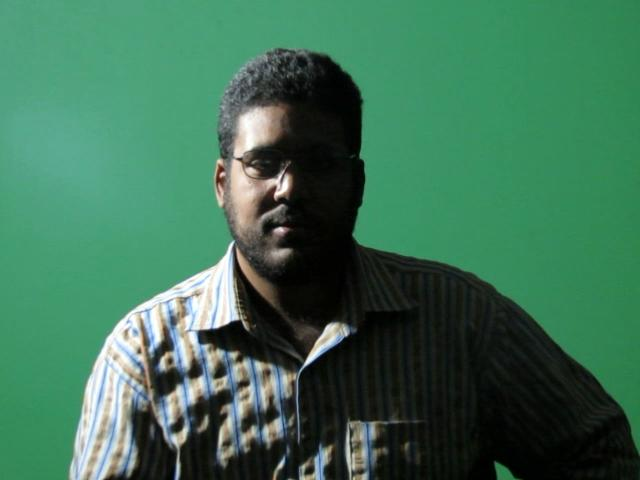

In [0]:
#Print 101th image to verify that import was successful
cv2_imshow(images[100]) 

In [0]:
images = np.array(images,dtype=np.float32)

Use MTCNN pre-trained model to detect and crop the faces from our images. This helps to remove noise from the images, so that the CNN models subsequently only focus on information derived from the faces and features within.
- https://github.com/ipazc/mtcnn
- https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

In [0]:
#Function to detect face from image and crop
from mtcnn.mtcnn import MTCNN
def detectFace(pic, faceDetected):
  detector = MTCNN()
  pixels = pic
  results = detector.detect_faces(pixels)
  if len(results)!=0:
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    faceDetected = True
    return face, faceDetected
  else:
    return np.nan, faceDetected

Using TensorFlow backend.


In [0]:
#Detect face from image and save cropped face + label to new folder
for pic in images:
  detection = False
  face, detection = detectFace(pic,detection)
  if detection==True:
    filename = '/content/gdrive/My Drive/Google_Collab/cropped images/'+ names[count]
    cv2.imwrite(filename,face)

Done cropping all images True


In [0]:
#Load cropped images (as greyscale) and filename into lists
croppedImages = []
croppedNames = []

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/cropped images'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/cropped images/' + filename
    pic = cv2.imread(filename1, 0)
    croppedImages.append(pic)
    croppedNames.append(filename)

print(len(croppedImages))
print(len(croppedNames))

2028
2028


In [0]:
#Remove wrongly cropped images (sort by size)
sortedList = sorted(zip(croppedImages,croppedNames), key=lambda x: x[0].shape)
del sortedList[:22]
len(sortedList)

2006

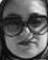

In [0]:
cv2_imshow(sortedList[0][0]) 

In [0]:
#Find the median size of image
print(sortedList[0][0].shape)
print(sortedList[1003][0].shape)
print(sortedList[2005][0].shape)

(60, 48)
(158, 116)
(477, 340)


In [0]:
imageSorted = [row[0] for row in sortedList]
descriptionSorted = [row[1] for row in sortedList]

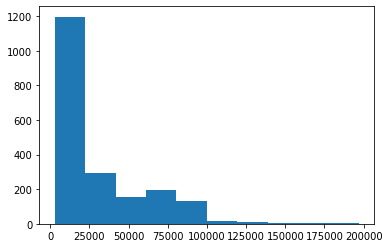

In [0]:
imageSize = list(map(lambda x: x.shape[0]*x.shape[1],imageSorted))
plt.hist(x=imageSize,bins=10);

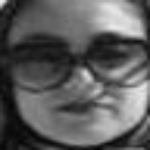

In [0]:
#Select dim = (150,150) ~ median image size in the dataset
dim = (150,150)
croppedImagesResized = []
for pic in imageSorted:
  croppedImagesResized.append(cv2.resize(pic, dim))
cv2_imshow(croppedImagesResized[0]) 

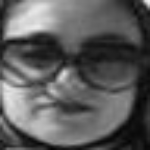

In [0]:
#Image augmentation (horizontal flip) to increase size of dataset
imagesHflip = []
for pic in croppedImagesResized:
  imagesHflip.append(cv2.flip(pic,1))

cv2_imshow(imagesHflip[0])

In [0]:
imagesCombined = croppedImagesResized + imagesHflip

In [0]:
#Normalise images (subtract mean, divide by std) to reduce effects of poor lighting
#Convert images to numpy array and dtype=float32
x = [(imageArray-imageArray.mean())/imageArray.std() for imageArray in imagesCombined]
x = np.array(x,dtype=np.float32)
x.shape

(4012, 150, 150)

In [0]:
#Image filename contains information about the image features
#Save list of filenames to dataframe for further analysis
#Duplicate rows to account for horizontal flipped images
targetDf = pd.DataFrame(descriptionSorted,columns=['filename'])
targetDf = targetDf.append([targetDf],ignore_index=True)
print(targetDf.shape)
targetDf.head()

(4012, 1)


,filename
0,RehM_02280_f_25_o_fr_nc_no_2015_1_e0_nl_o.jpg
1,HedA_00835_m_46_o_fr_nc_no_2016_1_e0_nl_o.jpg
2,HedA_00831_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg
3,HedA_00834_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg
4,ZenH_02662_f_24_o_nf_nc_no_2014_1_e0_nl_o.jpg


In [0]:
#Create new columns in dataframe to represent the important image features
#For this project, important features are: gender, age, emotion
new = targetDf["filename"].str.split('_', expand = True) 
targetDf['name']=new[0]
targetDf['gender']=new[2]
targetDf['age']=new[3]
targetDf['emotion']=new[7]
targetDf.head()

,filename,name,gender,age,emotion
0,RehM_02280_f_25_o_fr_nc_no_2015_1_e0_nl_o.jpg,RehM,f,25,no
1,HedA_00835_m_46_o_fr_nc_no_2016_1_e0_nl_o.jpg,HedA,m,46,no
2,HedA_00831_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg,HedA,m,45,no
3,HedA_00834_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg,HedA,m,45,no
4,ZenH_02662_f_24_o_nf_nc_no_2014_1_e0_nl_o.jpg,ZenH,f,24,no


Exploratory Data Analysis

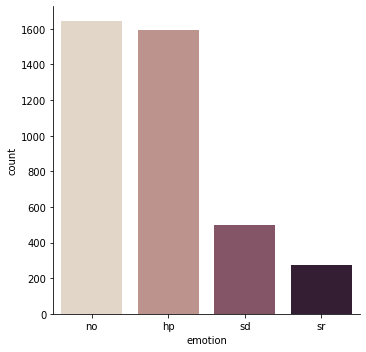

In [0]:
import seaborn as sns
sns.catplot(x="emotion", kind="count", palette="ch:.25", data=targetDf);

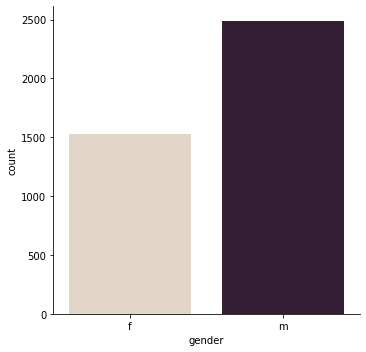

In [0]:
sns.catplot(x="gender", kind="count", palette="ch:.25", data=targetDf);

In [0]:
targetDf.dtypes

filename    object
name        object
gender      object
age         object
emotion     object
dtype: object

In [0]:
targetDf['age'] = targetDf['age'].astype(int)

In [0]:
targetDf.dtypes

filename    object
name        object
gender      object
age          int64
emotion     object
dtype: object

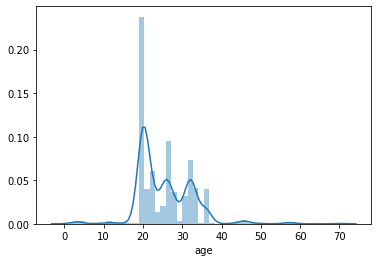

In [0]:
sns.distplot(targetDf['age']);

Feature Selection for Model

In [0]:
#Predicting emotions
#Convert string descriptions to categorical
targetDf['emotion'] = pd.Categorical(targetDf['emotion'])
targetDf['emotionCat'] = targetDf['emotion'].cat.codes
yEmotion = to_categorical(targetDf['emotionCat'])
yEmotion[:5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [0]:
yEmotion.shape

(4012, 4)

In [0]:
#Check the distribution of images for each emotion classification
#We have an imbalanced data set with majority of the images tagged with 'no' and 'hp'
print(targetDf['emotion'].value_counts())
print(targetDf['emotion'].value_counts(normalize=True))

no    1644
hp    1596
sd     496
sr     276
Name: emotion, dtype: int64
no    0.409771
hp    0.397807
sd    0.123629
sr    0.068794
Name: emotion, dtype: float64


In [0]:
print(targetDf['emotionCat'].value_counts())

1    1644
0    1596
2     496
3     276
Name: emotionCat, dtype: int64


In [0]:
indices = np.arange(len(targetDf['emotionCat']))
indices

array([   0,    1,    2, ..., 4009, 4010, 4011])

In [0]:
#Train Test Split image dataset, with stratification for emotion class
#Include indices to reference original images later
xTrainEmotion,xTestEmotion,yTrainEmotion,yTestEmotion,indicesTrain,indicesTest = train_test_split(x, 
                                                                                                  yEmotion,
                                                                                                  indices, 
                                                                                                  train_size=0.7, 
                                                                                                  random_state=42, 
                                                                                                  stratify=yEmotion)

In [0]:
print(xTrainEmotion.shape)
print(yTrainEmotion.shape)
print(indicesTrain.shape)

(2808, 150, 150)
(2808, 4)
(2808,)


In [0]:
#Reshape image array to (150,150,1) so the computer knows it is in grayscale
xTrainEmotion = xTrainEmotion.reshape(xTrainEmotion.shape[0], 150, 150, 1)
xTestEmotion = xTestEmotion.reshape(xTestEmotion.shape[0], 150, 150, 1)

In [0]:
#Save train-test-split results as npy file for ease of subsequent use
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotion.npy', xTrainEmotion)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy', xTestEmotion)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotion.npy', yTrainEmotion)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy', yTestEmotion)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/indicesTrain.npy', indicesTrain)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/indicesTest.npy', indicesTest)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/imagesCombined.npy', imagesCombined)
targetDf.to_csv('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/targetDf.csv')

In [0]:
xTrainEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotion.npy')
xTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy')
yTrainEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotion.npy')
yTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy')

Addition of CK+48 images to the train dataset

135


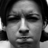

In [0]:
extraImagesAnger = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/anger'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/anger/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesAnger.append(pic)
    count+=1

countAnger = count
print(countAnger)
cv2_imshow(extraImagesAnger[0])

In [0]:
extraImagesAnger[0].shape

(48, 48)

54


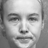

In [0]:
extraImagesContempt = []
count=0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/contempt'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/contempt/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesContempt.append(pic)
    count+=1

countContempt = count
print(countContempt)
cv2_imshow(extraImagesContempt[0])

177


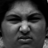

In [0]:
extraImagesDisgust = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/disgust'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/disgust/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesDisgust.append(pic)
    count+=1

countDisgust = count
print(countDisgust)
cv2_imshow(extraImagesDisgust[0])

75


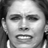

In [0]:
extraImagesFear = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/fear'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/fear/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesFear.append(pic)
    count+=1

countFear = count
print(countFear)
cv2_imshow(extraImagesFear[0])

207


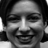

In [0]:
extraImagesHappy = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/happy'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/happy/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesHappy.append(pic)
    count+=1

countHappy = count
print(countHappy)
cv2_imshow(extraImagesHappy[0])

84


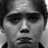

In [0]:
extraImagesSadness = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/sadness'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/sadness/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesSadness.append(pic)
    count+=1

countSadness = count
print(countSadness)
cv2_imshow(extraImagesSadness[0])

249


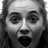

In [0]:
extraImagesSurprise = []
count = 0

for filename in os.listdir('/content/gdrive/My Drive/Google_Collab/CK+48/surprise'):
    filename1 = '/content/gdrive/My Drive/Google_Collab/CK+48/surprise/' + filename
    pic = cv2.imread(filename1, 0)
    extraImagesSurprise.append(pic)
    count+=1

countSurprise = count
print(countSurprise)
cv2_imshow(extraImagesSurprise[0])

Based on data dictionary,
- hp: happy
- sd: anger, contempt, disgust, sadness
- sr: fear, surprise 

In [0]:
totalHp = countHappy
totalSd = countAnger + countContempt + countDisgust + countSadness
totalSr = countFear + countSurprise
extraImagesEmotions = ['hp']*totalHp + ['sd']*totalSd + ['sr']*totalSr
print(type(extraImagesEmotions))
print(len(extraImagesEmotions))

<class 'list'>
981


In [0]:
extraImagesCombined = (extraImagesHappy + extraImagesAnger + extraImagesContempt +
                       extraImagesDisgust + extraImagesSadness + extraImagesFear +
                       extraImagesSurprise)
len(extraImagesCombined)

981

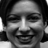

In [0]:
cv2_imshow(extraImagesCombined[0])

In [0]:
#Repeat data augmentation for extra images
extraImagesHflip = []
for pic in extraImagesCombined:
  extraImagesHflip.append(cv2.flip(pic,1))
extraImagesCombinedFlipped = extraImagesCombined + extraImagesHflip
len(extraImagesCombinedFlipped)

1962

In [0]:
#Similarly resize extra images to same dim = (150,150)
dim = (150,150)
extraImagesCombinedFlippedResized = []
for pic in extraImagesCombinedFlipped:
  extraImagesCombinedFlippedResized.append(cv2.resize(pic, dim))

In [0]:
extraImagesCombinedFlippedResized[0].shape

(150, 150)

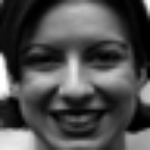

In [0]:
cv2_imshow(extraImagesCombinedFlippedResized[0])

In [0]:
x2 = [(imageArray-imageArray.mean())/imageArray.std() for imageArray in extraImagesCombinedFlippedResized]
x2 = np.array(x2,dtype=np.float32)
x2.shape

(1962, 150, 150)

In [0]:
#Generate and add labels for extra images
extraTargetDf = pd.DataFrame(extraImagesEmotions,columns=['emotion'])
extraTargetDf = extraTargetDf.append([extraTargetDf],ignore_index=True)
extraTargetDf['emotion'] = pd.Categorical(extraTargetDf['emotion'])
extraTargetDf['emotionCat'] = extraTargetDf['emotion'].cat.codes
extraYEmotion = to_categorical(extraTargetDf['emotionCat'])
extraYEmotion[:-5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [0]:
extraYEmotion.shape

(1962, 3)

In [0]:
#Add column because extra images does not contain faces with "neutral" emotion label
z = np.zeros((1962,1))
extraYEmotion = np.append(z,extraYEmotion, axis=1)
extraYEmotion[:-5]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [0]:
x2 = x2.reshape(x2.shape[0], 150, 150, 1)

In [0]:
xTrainEmotionExtraData = np.append(xTrainEmotion,x2,axis=0)
len(xTrainEmotionExtraData)

4770

In [0]:
yTrainEmotionExtraData = np.append(yTrainEmotion, extraYEmotion, axis=0)
len(yTrainEmotionExtraData)

4770

In [0]:
print(type(xTrainEmotionExtraData))
print(type(yTrainEmotionExtraData))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
#Save updated train/test dataset as npy for subsequent use
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotionExtraData.npy', xTrainEmotionExtraData)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy', xTestEmotion)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotionExtraData.npy', yTrainEmotionExtraData)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy', yTestEmotion)

In [0]:
xTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTrainEmotionExtraData.npy')
xTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/xTestEmotion.npy')
yTrainEmotionExtraData = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTrainEmotionExtraData.npy')
yTestEmotion = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsEmotion/yTestEmotion.npy')
print(len(xTrainEmotionExtraData))
print(type(xTrainEmotionExtraData))

4770
<class 'numpy.ndarray'>


In [0]:
#Predicting gender
targetDf['genderCat'] = targetDf['gender'].map(lambda x: 1 if x=='m' else 0)
targetDf.head()

,filename,name,gender,age,emotion,emotionCat,genderCat
0,RehM_02280_f_25_o_fr_nc_no_2015_1_e0_nl_o.jpg,RehM,f,25,no,1,0
1,HedA_00835_m_46_o_fr_nc_no_2016_1_e0_nl_o.jpg,HedA,m,46,no,1,1
2,HedA_00831_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg,HedA,m,45,no,1,1
3,HedA_00834_m_45_o_fr_nc_no_2015_1_e0_nl_o.jpg,HedA,m,45,no,1,1
4,ZenH_02662_f_24_o_nf_nc_no_2014_1_e0_nl_o.jpg,ZenH,f,24,no,1,0


In [0]:
print(targetDf['gender'].value_counts())
print(targetDf['genderCat'].value_counts(normalize=True))

m    2488
f    1524
Name: gender, dtype: int64
1    0.62014
0    0.37986
Name: genderCat, dtype: float64


In [0]:
yGender = targetDf['genderCat']
yGender.shape

(4012,)

In [0]:
#Stratify gender dataset similarly to the emotion dataset previously, to ensure same test set for each model
xTrainGender, xTestGender, yTrainGender, yTestGender = train_test_split(x, 
                                                                        yGender, 
                                                                        train_size=0.7, 
                                                                        random_state=42, 
                                                                        stratify=yEmotion)

In [0]:
xTrainGender = xTrainGender.reshape(xTrainGender.shape[0], 150, 150, 1)
xTestGender = xTestGender.reshape(xTestGender.shape[0], 150, 150, 1)

In [0]:
print (np.all(xTestGender == xTestEmotion))

True


In [0]:
yTrainGender.describe()

count    2808.000000
mean        0.624644
std         0.484301
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: genderCat, dtype: float64

In [0]:
yTestGender.describe()

count    1204.000000
mean        0.609635
std         0.488035
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: genderCat, dtype: float64

In [0]:
#Save train/test gender dataset for ease of future use
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/xTrainGender.npy', xTrainGender)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/xTestGender.npy', xTestGender)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/yTrainGender.npy', yTrainGender)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/yTestGender.npy', yTestGender)

In [0]:
xTrainGender = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/xTrainGender.npy')
xTestGender = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/xTestGender.npy')
yTrainGender = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/yTrainGender.npy')
yTestGender = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsGender/yTestGender.npy')

In [0]:
#Predicting age
targetDf['age'].describe()

count     4012
unique      41
top         20
freq      1216
Name: age, dtype: object

In [0]:
yAge = targetDf['age']
yAge.shape

(4012,)

In [0]:
#Similarly, stratify age dataset by yEmotion, to ensure same test set for each model
xTrainAge, xTestAge, yTrainAge, yTestAge = train_test_split(x, 
                                                            yAge, 
                                                            train_size=0.7, 
                                                            random_state=42, 
                                                            stratify=yEmotion)

In [0]:
xTrainAge = xTrainAge.reshape(xTrainAge.shape[0], 150, 150, 1)
xTestAge = xTestAge.reshape(xTestAge.shape[0], 150, 150, 1)

In [0]:
print (np.all(xTestAge == xTestEmotion))

True


In [0]:
yTrainAge.describe()

count     2808
unique      40
top         20
freq       839
Name: age, dtype: object

In [0]:
yTestAge.describe()

count     1204
unique      39
top         20
freq       377
Name: age, dtype: object

In [0]:
#Save train/test age dataset for ease of future use
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/xTrainAge.npy', xTrainAge)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/xTestAge.npy', xTestAge)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/yTrainAge.npy', yTrainAge)
np.save('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/yTestAge.npy', yTestAge)

In [0]:
xTrainAge = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/xTrainAge.npy', allow_pickle=True)
xTestAge = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/xTestAge.npy', allow_pickle=True)
yTrainAge = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/yTrainAge.npy', allow_pickle=True)
yTestAge = np.load('/content/gdrive/My Drive/Google_Collab/CNNModelsAge/yTestAge.npy', allow_pickle=True)